# Classification on Google ML with Keras

## Setup

### Configuration

In [1]:
ROOT_PATH = '../services/classification-keras'

MODEL_PATH = '%s/models' % (ROOT_PATH)
EXPORTED_MODEL_PATH = '%s/keras_exported_model' % (MODEL_PATH)

DATA_PATH = '%s/data' % (ROOT_PATH)
DATA_INPUT_IMAGE_PATH = '%s/images/frog.png' % (DATA_PATH)
DATA_INPUT_JSON_PATH = './sample_image.json'

BUCKET_NAME = 'keras_image-classification-1000'
BUCKET_FOLDER_NAME = 'classify_v1'
BUCKET_URL = 'gs://%s' % (BUCKET_NAME)
BUCKET_FOLDER_URL = '%s/%s' % (BUCKET_URL, BUCKET_FOLDER_NAME)

MODEL_NAME = 'keras_image_classification'
MODEL_VERSION = 'v1'
MODEL_RUNTIME_VERSION = '1.10'

PROJECT_ID = "gde-core-dev"
REGION = 'us-central1'
CREDENTIALS_FILE = "./credentials.json"

### Libraries

- google-api-python-client
- oauth2client
- pickle

In [2]:
import os
import json

import pickle
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import image

from oauth2client.client import GoogleCredentials
import googleapiclient.discovery

Using TensorFlow backend.


### Constants

In [3]:
# These are the CIFAR10 class labels from the training data (in order from 0 to 9)
cifar10_class_names = [
    "Plane",
    "Car",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Boat",
    "Truck"
]

### Upload the model to Google Cloud bucket

In [4]:
# Make the bucket
!gsutil mb -l { REGION } { BUCKET_URL }
!gsutil cp -r { EXPORTED_MODEL_PATH } { BUCKET_FOLDER_URL }

Creating gs://keras_image-classification-1000/...
Copying file://../services/classification-keras/models/keras_exported_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://../services/classification-keras/models/keras_exported_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://../services/classification-keras/models/keras_exported_model/variables/variables.index [Content-Type=application/octet-stream]...
| [3 files][ 29.1 MiB/ 29.1 MiB]                                                
Operation completed over 3 objects/29.1 MiB.                                     


### Create the model with Google ML Engine

In [5]:
!gcloud ml-engine models create { MODEL_NAME } --regions { REGION }

Created ml engine model [projects/gde-core-dev/models/keras_image_classification].


In [6]:
!gcloud ml-engine versions create { MODEL_VERSION } \
    --model={ MODEL_NAME } \
    --origin={ BUCKET_FOLDER_URL }/ \
    --runtime-version={ MODEL_RUNTIME_VERSION }

Creating version (this might take a few minutes)......done.                    


## Prediction

### Input

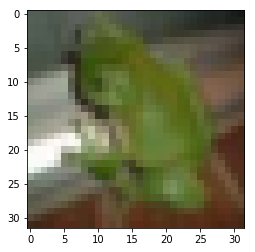

In [7]:
# Load an image file to test, resizing it to 32x32 pixels (as required by this model)
img = image.load_img(DATA_INPUT_IMAGE_PATH, target_size=(32, 32))

# Convert the image to a numpy array
image_to_test = image.img_to_array(img)

# Normalize data set to 0-to-1 range
norm_image = image_to_test.astype('float32') / 255

# Draw the image as a plot
plt.imshow(norm_image)

# Show the plot on the screen
plt.show()

In [8]:
input = norm_image.tolist()

# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
inputs = np.expand_dims(norm_image, axis=0).tolist()

json_input = {
    "input": input
}
with open(DATA_INPUT_JSON_PATH, 'w') as outfile:
    json.dump(json_input, outfile)
    
!pygmentize { DATA_INPUT_JSON_PATH }

{"input": [[[0.32549020648002625, 0.3686274588108063, 0.3333333432674408], [0.32156863808631897, 0.3686274588108063, 0.3294117748737335], [0.3176470696926117, 0.364705890417099, 0.32549020648002625], [0.3019607961177826, 0.3490196168422699, 0.30980393290519714], [0.3176470696926117, 0.3529411852359772, 0.3137255012989044], [0.3333333432674408, 0.3529411852359772, 0.32156863808631897], [0.35686275362968445, 0.3764705955982208, 0.364705890417099], [0.3607843220233917, 0.3764705955982208, 0.37254902720451355], [0.3607843220233917, 0.3803921639919281, 0.3529411852359772], [0.37254902720451355, 0.4000000059604645, 0.3333333432674408], [0.3960784375667572, 0.4313725531101227, 0.30980393290519714], [0.3607843220233917, 0.3960784375667572, 0.2823529541492462], [0.34117648005485535, 0.3686274588108063, 0.29411765933036804], [0.32156863808631897, 0.3450980484485626, 0.30588236451148987], [0.3137255012989044, 0.3333333432674408, 0.3294117748737335], [0.2980392277240753, 0.32156863808631897, 0.309

### Predict with Google ML using gcloud

In [9]:
output = !gcloud ml-engine predict \
    --model={ MODEL_NAME } \
    --json-instances={ DATA_INPUT_JSON_PATH }

print(output)

single_result = eval(output[1])

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
most_likely_class_index = int(np.argmax(single_result))
class_likelihood = single_result[most_likely_class_index]

# Get the name of the most likely class
class_label = cifar10_class_names[most_likely_class_index]

# Print the result
print("This is image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))

['SCORES', '[6.133701390353963e-06, 2.39029304793803e-07, 0.09792765974998474, 0.0017051560571417212, 0.0010592438047751784, 5.7568478950997815e-05, 0.8992279767990112, 2.649228235895862e-06, 1.3096969269099645e-06, 1.2033864550176077e-05]']
This is image is a Frog - Likelihood: 0.899228


### Predict from Google ML Engine using SDK

In [10]:
# These are the values we want a prediction for
inputs_for_prediction = [{
    "input": input
}]

# Connect to the Google Cloud-ML Service
credentials = GoogleCredentials.from_stream(CREDENTIALS_FILE)
service = googleapiclient.discovery.build('ml', 'v1', credentials=credentials)

# Connect to our Prediction Model
name = 'projects/{}/models/{}'.format(PROJECT_ID, MODEL_NAME)
response = service.projects().predict(
    name=name,
    body={'instances': inputs_for_prediction}
).execute()

# Report any errors
if 'error' in response:
    raise RuntimeError(response['error'])

print(response)
    
# Grab the results from the response object
results = response['predictions']

single_result = results[0]['scores']

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
most_likely_class_index = int(np.argmax(single_result))
class_likelihood = single_result[most_likely_class_index]

# Get the name of the most likely class
class_label = cifar10_class_names[most_likely_class_index]

# Print the result
print("This is image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))


{'predictions': [{'scores': [6.133701390353963e-06, 2.39029304793803e-07, 0.09792765974998474, 0.0017051560571417212, 0.0010592438047751784, 5.7568478950997815e-05, 0.8992279767990112, 2.649228235895862e-06, 1.3096969269099645e-06, 1.2033864550176077e-05]}]}
This is image is a Frog - Likelihood: 0.899228


## Tear down

### Delete the model from Google ML Engine

In [11]:
!gcloud ml-engine versions delete { MODEL_VERSION } \
    --model={ MODEL_NAME } \
    --quiet
!gcloud ml-engine models delete { MODEL_NAME } --quiet

Deleting version [v1]......done.                                               
Deleting model [keras_image_classification]...done.                            


In [12]:
!gsutil -m rm -r { BUCKET_URL } 

Removing gs://keras_image-classification-1000/classify_v1/saved_model.pb#1540507926058683...
Removing gs://keras_image-classification-1000/classify_v1/variables/variables.data-00000-of-00001#1540507927676831...
Removing gs://keras_image-classification-1000/classify_v1/variables/variables.index#1540507927899818...
/ [3/3 objects] 100% Done                                                       
Operation completed over 3 objects.                                              
Removing gs://keras_image-classification-1000/...


In [14]:
os.remove(DATA_INPUT_JSON_PATH)

## Troubleshooting

In [15]:
# Check the model signature with saved_model_cli

!saved_model_cli show --dir { EXPORTED_MODEL_PATH }  --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: conv2d_1_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: dense_2_1/Softmax:0
  Method name is: tensorflow/serving/classify


In [16]:
# Test prediction with saved_model_cli

!saved_model_cli run \
    --dir { EXPORTED_MODEL_PATH } \
    --tag_set serve \
    --signature_def serving_default \
    --input_exprs 'input={ inputs }' \
    --outdir=. \
    --overwrite

results = np.load('./scores.npy')
os.remove("./scores.npy")

single_result = results[0]

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
most_likely_class_index = int(np.argmax(single_result))
class_likelihood = single_result[most_likely_class_index]

# Get the name of the most likely class
class_label = cifar10_class_names[most_likely_class_index]

# Print the result
print("This is image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))

2018-10-25 15:55:58.786055: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Result for output key scores:
[[6.1336968e-06 2.3902891e-07 9.7927533e-02 1.7051548e-03 1.0592425e-03
  5.7568377e-05 8.9922816e-01 2.6492237e-06 1.3096960e-06 1.2033866e-05]]
Output scores is saved to ./scores.npy
This is image is a Frog - Likelihood: 0.899228
